📚 | Import Libraries

In [ ]:
!pip install keras_nlp
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch"

import keras_nlp # This line caused the ModuleNotFoundError
import keras
import keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

<ipython-input-12-ead4ecd52d1f>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')



Library Version

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.17.0
Keras: 3.4.1
KerasNLP: 0.14.4


⚙️ | Configuration

In [ ]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

♻️ | Reproducibility

Sets value for random seed to produce similar result in each run

In [ ]:
keras.utils.set_random_seed(CFG.seed)

🧮 | Mixed Precision

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")


📖 | Meta Data¶
Files in the dataset:

{test|train}.csv
essay_id: Unique identifier for each essay.
full_text: Essay text.
score: Essay's score from 1-6.
sample_submission.csv: Valid sample submission.
What does the score mean?

The score represents the quality of student-written argumentative essays. Essays were rated based on a rubric covering perspective development, critical thinking, evidence use, organization, language, and grammar/mechanics. Here's a summary of the scoring criteria:

Score	Description
6	Clear mastery with few errors, outstanding critical thinking, appropriate evidence, well-organized, skilled language use.
5	Reasonable mastery with occasional errors, strong critical thinking, generally appropriate evidence, well-organized, good language use.
4	Adequate mastery with some lapses, competent critical thinking, adequate evidence, generally organized, fair language use.
3	Developing mastery with weaknesses, limited critical thinking, inconsistent evidence, limited organization, fair language use with weaknesses.
2	Little mastery with serious flaws, weak critical thinking, insufficient evidence, poor organization, limited language use with frequent errors.
1	Very little or no mastery, severely flawed, no viable point of view, disorganized, fundamental language flaws, pervasive grammar/mechanics errors.
This grading is very similar to the grading used in the ETS GRE (Graduate Record Examinations) AWA exam, where prospective graduate students are asked to write essays to judge their analytical abilities, and their scores are later used for graduate admission.


 Load data

In [ ]:
# Load data
data= pd.read_csv("/content/drive/MyDrive/ML/train.csv",index_col=0)
data

,full_text,score
essay_id,,
000d118,Many people have car where they live. The thin...,3
000fe60,I am a scientist at NASA that is discussing th...,3
001ab80,People always wish they had the same technolog...,4
001bdc0,"We all heard about Venus, the planet without a...",4
002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...
ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
ffddf1f,Technology has changed a lot of ways that we l...,4
fff016d,If you don't like sitting around all day than ...,2


#load test data


In [ ]:
# Load data
test= pd.read_csv("/content/drive/MyDrive/ML/test data .csv",index_col=0)
test

,score
essay_id,
000d118,3
000fe60,3
001ab80,4
001bdc0,4
002ba53,3
...,...
ffd378d,2
ffddf1f,4
fff016d,2


In [ ]:
# Explore shapes of data and labels
print(f"Shape of data {data.shape}")
print(f"Shape of data {test.shape}")

Shape of data (17307, 2)
Shape of data (17307, 1)


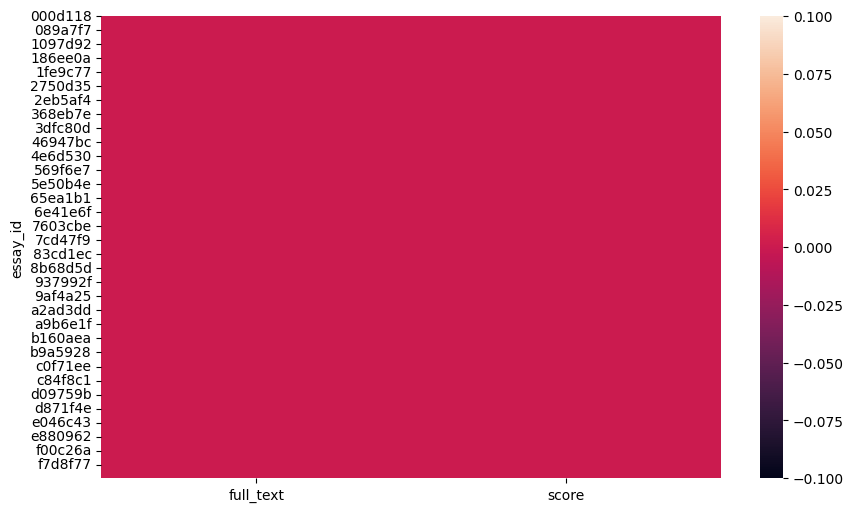

In [ ]:
# a heat map to visualize the missing values in the data
!pip install seaborn
import seaborn as sns # Import the seaborn library and alias it as sns
import matplotlib.pyplot as plt # Import the matplotlib library and alias it as plt

plt.figure(figsize= (10,6))
sns.heatmap(data.isnull())
plt.show()

In [ ]:
# confirm there is no Null
data.isnull().any().sum()


0

In [ ]:
import numpy as np
import pandas as pd

# Replace outliers with the upper and lower IQR bounds
def outliers(data):
    for col in data.select_dtypes(include=np.number).columns:  # Apply only to numerical columns
        IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
        lower_bound = data[col].quantile(0.25) - 1.5 * IQR
        upper_bound = data[col].quantile(0.75) + 1.5 * IQR
        data[col] = np.where(data[col] >= upper_bound, upper_bound, data[col])
        data[col] = np.where(data[col] <= lower_bound, lower_bound, data[col])
    return data

# Apply it to data
data = outliers(data)
data.shape

(17307, 2)

In [ ]:
# split x as features and y as test
x= data
y= test.iloc[:,0]

🔪 | Data Split
In the code snippet provided below, we will divide the existing train data into folds using a stratification of label column.

In [ ]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(data, test_size=0.2, stratify=data["score"]) # Changed df to data

In [ ]:
# split data 80% training and 20% testing
import pandas as pd
from sklearn.model_selection import train_test_split
# Now split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

🧂 | Process Labels for Ordinal Regression
What is Ordinal Regression? Ordinal regression is a type of supervised learning algorithm used to predict an ordinal or ranked dependent variable. Unlike in typical classification problems where the target variable is categorical, in ordinal regression the target variable has a ordering or ranking. It is also different from typical regression, where the target variable is continuous. In ordinal regression, the target variable has a discrete, ordered set of values, such as levels of satisfaction or performance grades.

Why do we need it? Ordinal regression is useful when the target variable (in our competition, the score of an essay) represents a ranking or order. Specifically, ordinal regression can capture the inherent order in the target variable, which standard classification models may not be able to do effectively.

For Ordinal Regression, we have to transform the labels, which is different from typical classification or regression. The following code will convert essay scores to an ordinal matrix, which will be used as the ground truth for calculating the loss.

In [ ]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [ ]:
scores = [1, 3, 5, 2, 6]

to_ordinal(scores)

array([[1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)

Label Conversion

In [ ]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

🎨 | EDA

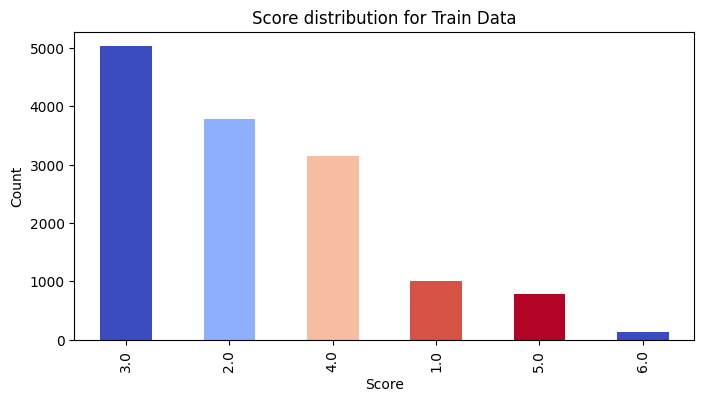

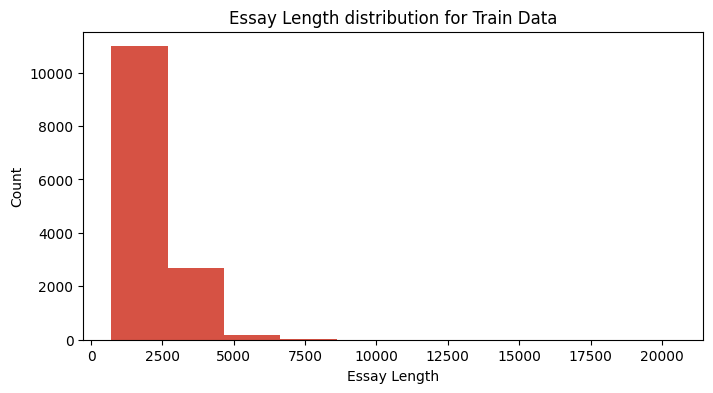

In [ ]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
train_df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)]) # Changed df to train_df
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
train_df['essay_length'] = train_df.full_text.map(len) # Changed df to train_df
train_df.essay_length.plot.hist(logy=False, color=cmap(0.9)) # Changed df to train_df
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

🍽️ | Preprocessing
What it does: The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

Why it's important: Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming "The quick brown fox" into ["the", "qu", "##ick", "br", "##own", "fox"], we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

100%|██████████| 140/140 [00:00<00:00, 211kB/s]


100%|██████████| 424/424 [00:00<00:00, 674kB/s]


100%|██████████| 2.35M/2.35M [00:00<00:00, 11.0MB/s]


In [ ]:
# Ensure that 'df' is defined and contains the expected DataFrame.
# If 'df' is not defined, you'll need to create or load it
# with the appropriate data. For example, you might load it from a CSV file:

import pandas as pd
df =pd.read_csv("/content/drive/MyDrive/ML/train.csv",index_col=0)

# Now you can use 'df'
inp = preprocessor(df.full_text.iloc[0])

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (512,)
padding_mask : (512,)


We'll use the preprocessing_fn function to transform each text option using the dataset.map(preprocessing_fn) method.

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

🍚 | DataLoader
The code below sets up a robust data flow pipeline using tf.data.Dataset for data processing. Notable aspects of tf.data include its ability to simplify pipeline construction and represent components in sequences.

To learn more about tf.data

In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds


Build Train/Valid Dataset
The function below generates the training and validation datasets

In [ ]:
# Train Data
train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)

⚓ | LR Schedule
Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:

step: Lowering the learning rate in step-wise manner resembling stairs.
cos: Utilizing a cosine curve to gradually reduce the learning rate.
exp: Exponentially decreasing the learning rate.
Importance: A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

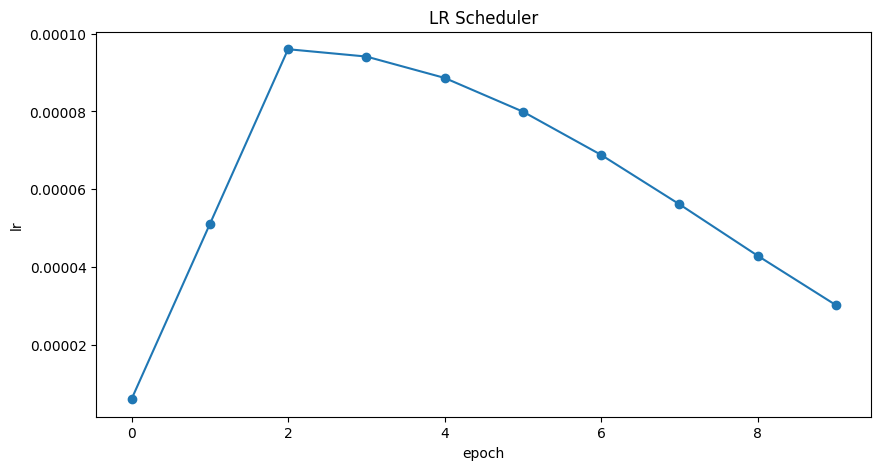

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

💾 | Model Checkpointing
The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)

📏 | Metric
The metric for this competition is quadratic Weighted Kappa. This metric is particularly useful for tasks involving ordinal classification (where labels have inherent order). The following code implements this metric from scratch.

In [ ]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)

🤖 | Modeling¶
KerasNLP Classifier
The KerasNLP library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including Bert, Roberta, DebertaV3, and more. In this notebook, we'll showcase the usage of DebertaV3. However, feel free to explore all available models in the KerasNLP documentation. Also, for a deeper understanding of KerasNLP, refer to the informative getting started guide.

Our approach involves using keras_nlp.models.DebertaV3Classifier to process each text and generate logits. These logits are passed through a sigmoid function to produce the final output.

Note that we are tackling this problem as an ordinal regression problem, thus we have used sigmoid activation, but we can also consider this problem as a classification problem; then, we would've used num_classes=6, softmax activation, and categorical_crossentropy loss. We could even consider this as a regression problem with num_classes=1, no activation layer, and regression losses like MSE, MAE, etc. You are welcome to experiment with the typical classification and regression methods.

In [ ]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()




100%|██████████| 539/539 [00:00<00:00, 832kB/s]


100%|██████████| 270M/270M [00:04<00:00, 59.8MB/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deberta_v3_classifier     │ (None, 6)              │     70,832,262 │ padding_mask[0][0],    │
│ (DebertaV3Classifier)     │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 6)              │              0 │ deberta_v3_classifier… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        # Ensure initializers are callable
        self.numerator = self.add_weight(name="numerator", initializer='zeros')
        self.denominator = self.add_weight(name="denominator", initializer='zeros')
        self.o_sum = self.add_weight(name="o_sum", initializer='zeros')
        self.e_sum = self.add_weight(name="e_sum", initializer='zeros')

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
